In [1]:
# Import statements
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from langdetect import detect

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# reads in each csv datasets as a pandas dataframe
def read_data(file):
    # Broadening possible missing values
    missing_values = ["n/a", "na", "--", "-", "NaN", "N/A", 'no title', ""] 
    read_file = pd.read_csv(file, index_col = False, delimiter = ',', header=0, na_values = missing_values)
    
    return read_file

PATH = "/content/drive/My Drive/Data/"

# create dataframes and keep only necessary features to join dataframes
fake_news1_labelled = read_data(PATH + "train.csv").loc[:,["title", "text", "label"]]
fake_news1_test = read_data(PATH + "test.csv")
fake_news1_testlabels = read_data(PATH + "submit.csv")
fake_news2 = read_data(PATH + "fake.csv").loc[:,["title", "text", "language"]]
politifact_real = read_data(PATH + "PolitiFact_real_news_content.csv").loc[:,["title", "text"]]
politifact_fake = read_data(PATH + "PolitiFact_fake_news_content.csv").loc[:,["title", "text"]]
buzzfeed_real = read_data(PATH + "BuzzFeed_real_news_content.csv").loc[:,["title", "text"]]
buzzfeed_fake = read_data(PATH + "BuzzFeed_fake_news_content.csv").loc[:,["title", "text"]]
news_labelled = read_data(PATH + "news_articles.csv").loc[:,["title", "text", "language", "label"]]
signal_sample = read_data(PATH + "signal_sample.csv")

In [3]:
# merge test data with their labels
fake_news1_test_labelled = fake_news1_test.merge(fake_news1_testlabels, on = "id").loc[:,["title", "text", "label"]]

In [4]:
# remove instances that are not in engilsh
def remove_non_english(df):
    
    df = df[df.language == "english"]
    
    return df

fake_news2_update = remove_non_english(fake_news2).loc[:,["title", "text"]]
news_labelled_update = remove_non_english(news_labelled).loc[:,["title", "text", "label"]]

In [5]:
# assigns 1 (fake) as the label for all instances in the dataframe
def fake_label(fake_df):
    
    fake_df["label"] = 1
    
    return fake_df

# assigns 0 (real) as the label for all instances in the dataframe
def real_label(real_df):
    
    real_df["label"] = 0
    
    return real_df


fake_news2_labelled = fake_label(fake_news2_update)
politifact_fake_labelled = fake_label(politifact_fake)
buzzfeed_fake_labelled = fake_label(buzzfeed_fake)

politifact_real_labelled = real_label(politifact_real)
buzzfeed_real_labelled = real_label(buzzfeed_real)
signal_labelled = real_label(signal_sample)

# rename 'fake' to 1 and 'real' to 0
news_labelled_update["label"] = news_labelled_update["label"].replace({"Fake": 1, "Real": 0})

In [6]:
# rename "content" column to "text"
signal_labelled_update = signal_labelled.rename(columns = {"content":"text"}).loc[:,["title", "text", "label"]]

[Text(0, 0, 'Fake News Net'),
 Text(0, 0, 'Politifact'),
 Text(0, 0, 'Buzzfeed'),
 Text(0, 0, 'Source based'),
 Text(0, 0, 'Fake News'),
 Text(0, 0, 'Signal')]

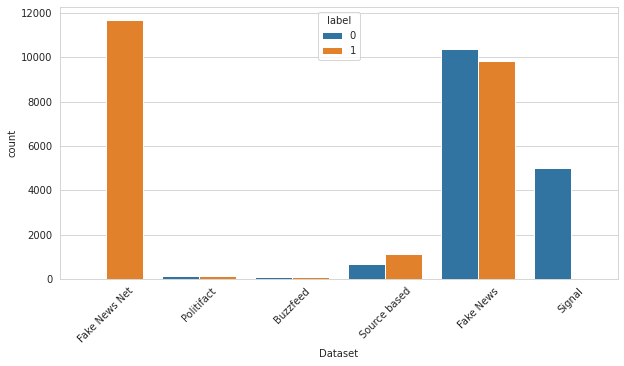

In [7]:
# Creating countplot with amount of true/false data for each dataset

# first, editing dataset to display dataset titles
politifact = pd.concat([politifact_fake_labelled, politifact_real_labelled]).reset_index().loc[:,["title", "text", "label"]]
buzzfeed = pd.concat([buzzfeed_fake_labelled, buzzfeed_real_labelled]).reset_index().loc[:,["title", "text", "label"]]
politifact['Dataset'] = 'Politifact'
buzzfeed['Dataset'] = 'Buzzfeed'
signal_labelled_update['Dataset'] = 'Signal'
fake_news2_labelled['Dataset'] = 'Fake News Net'
fake_news1_labelled['Dataset'] = 'Fake News'
news_labelled_update['Dataset'] = 'Source based'

# Creating list for df
news_df_list = [fake_news2_labelled, politifact, buzzfeed, news_labelled_update, fake_news1_labelled, 
                fake_news1_test_labelled, signal_labelled_update]

# Concatenate dataframes into one whole dataframe
all_news_labelled = pd.concat(news_df_list).reset_index().loc[:,["title", "text", "label", "Dataset"]].dropna()

# Plotting countplot with true/false for each dataste
plt.figure(figsize=(10,5))
sns.set_style("whitegrid")
ax = sns.countplot(x="Dataset", hue="label", data = all_news_labelled)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

In [8]:
# create a list of all dataframe
news_df_list = [fake_news2_labelled, politifact_fake_labelled, buzzfeed_fake_labelled, politifact_real_labelled, 
                buzzfeed_real_labelled, news_labelled_update, fake_news1_labelled, 
                fake_news1_test_labelled, signal_labelled_update]

# concatenate dataframes into one whole dataframe, removing null values and duplicates
all_news = pd.concat(news_df_list).reset_index().loc[:,["title", "text", "label"]].dropna()


In [9]:
all_news.groupby("label").count()

,title,text
label,,
0,18601,18601
1,25558,25558


In [10]:
all_news.head(10)

title    44159
text     44159
label    44159
dtype: int64


In [11]:
# Removing duplicate values based on text, keeping the first instance
all_news = all_news.drop_duplicates(subset = ["title", "text"], keep='first')
all_news = all_news.drop_duplicates(subset=['text'], keep='first')

In [13]:
# Removing any instances with non-alphanumeric characters
def is_en(txt):
  '''
  Function modified from similar work by Bruno Mello on 
  https://stackoverflow.com/questions/60930935/exclude-non-english-rows-in-pandas
  '''
  try:
    return detect(txt)=='en'
  except:
    return False



def dropNonEnglish(df):
  '''
  Requires input of df (Pandas DataFrame), deletes all non-English instances, 
  displays count, and returns dataframe.
  '''
  df['isEng'] = df['title'].apply(lambda x: is_en(x))

  # Display count
  print(df.groupby(df['isEng']).count())

  # Delete those not in english
  df = df.loc[df['isEng'] == True] 

  # Returns df
  return df.drop(['isEng'], axis = 1)
  
# Run dataset through fn to drop non-english
all_news = dropNonEnglish(all_news)

       title   text  label
isEng                     
False   1716   1716   1716
True   30049  30049  30049


Title Words:
Quantile  1 =  9.0
Quantile 3 =  15.0
Mean =  12.051016672767812
Median =  12.0
Inter-quartile Range =  6.0
Number of Outliers:  48 

Text Words:
Quantile  1 =  260.0
Quantile 3 =  996.0
Mean =  724.1092630245658
Median =  518.0
Inter-quartile Range =  736.0
Number of Outliers:  404 

Title Letters:
Quantile  1 =  57.0
Quantile 3 =  86.0
Mean =  72.30932189073216
Median =  73.0
Inter-quartile Range =  29.0
Number of Outliers:  49 

Text Letters:
Quantile  1 =  1555.0
Quantile 3 =  5790.25
Mean =  3976.945816975768
Median =  3087.5
Inter-quartile Range =  4235.25
Number of Outliers:  35 



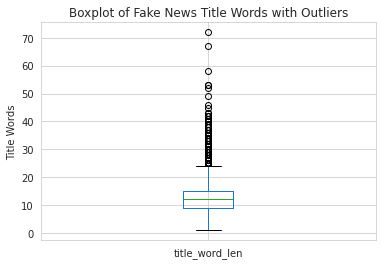

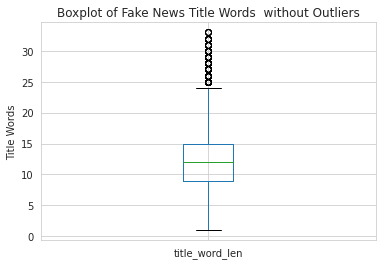

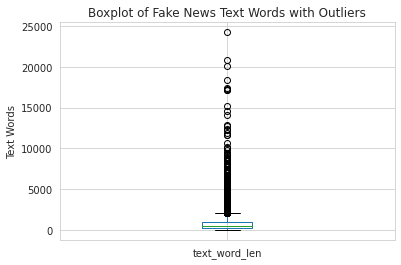

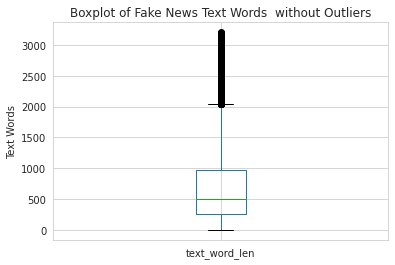

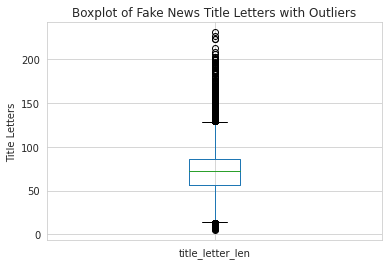

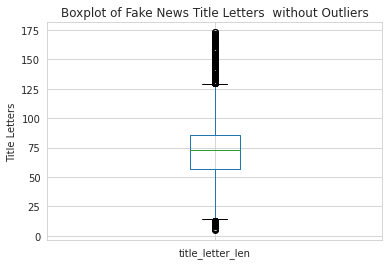

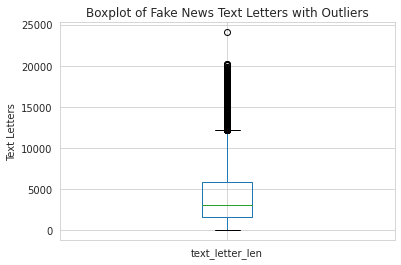

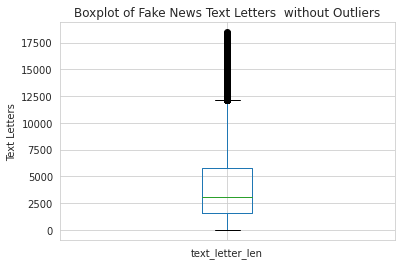

In [15]:
# Creating two functions to utilise in removing outliers from the df, 
# printing out summary stats and boxplots throughout

def removeFeatureOutliers(df, ref, name):
  '''
  Function takes input df(Pandas DataFrame), ref(String- reference to column in 
  df for outlier analysis), name(String- To display for output). 

  Function prints out out summary statistics and boxplots before and after 
  outlier removal for feature. 

  Returns dataframe with outliers removed for input feature. 
  '''
  # Define quartiles 
  q1 = df[ref].quantile(.25)
  q3 = df[ref].quantile(.75)
  iqr = q3-q1

  # Print out summary stats
  print(name + ":")
  print('Quantile  1 = ',q1)
  print('Quantile 3 = ', q3)
  print("Mean = ", df[ref].mean())
  print("Median = ", df[ref].median())
  print("Inter-quartile Range = ",iqr)

  # Define outliers
  outliers =  df[ref][(df[ref] > q3+3*iqr) | (df[ref] < q1-3*iqr)] 
  print("Number of Outliers: ", outliers.size, "\n")

  # Display boxplot with outliers
  fig, ax = plt.subplots()
  ax.set_ylabel(name)
  df[ref].plot(kind='box').set_title('Boxplot of Fake News ' + name + ' with Outliers')  

  # Removing outliers
  df = df.drop(outliers.index)

  # Re-displaying boxplot without outliers
  fig, ax = plt.subplots()
  ax.set_ylabel(name)
  df[ref].plot(kind='box').set_title('Boxplot of Fake News ' + name + ' without Outliers')

  # Returning dataFrame
  return df

def removeAllOutliers(df):
  '''
  Function takes input df(Pandas DataFrame). 

  Function creates features for word and letter lengths for title and text of 
  fake news and removes outliers for all.

  Returns dataframe with all forms of outliers removed. 
  '''
  # Defining each feature to create
  str_xw = 'text_word_len'
  str_xl = 'text_letter_len'
  str_tw = 'title_word_len'
  str_tl = 'title_letter_len'

  # Adding columns with word and letter length for title and text
  df[str_xw] = df['text'].apply(lambda x: len(x.split()))
  df[str_tw] = df['title'].apply(lambda x: len(x.split()))
  df[str_xl] = df['text'].apply(len)
  df[str_tl] = df['title'].apply(len)

  # Inputting each into fn to remove outliers
  df1 = removeFeatureOutliers(df, str_tw, "Title Words")
  df2 = removeFeatureOutliers(df1, str_xw, "Text Words")
  df3 = removeFeatureOutliers(df2, str_tl, "Title Letters")
  df4 = removeFeatureOutliers(df3, str_xl, "Text Letters")

  return df4


news_data_stats = removeAllOutliers(all_news)

In [17]:
news_data_stats.describe()

,label,text_word_len,title_word_len,text_letter_len,title_letter_len
count,29513.000000,29513.000000,29513.000000,29513.000000,29513.000000
mean,0.432725,659.059940,11.980009,3958.705282,72.120489
std,0.495462,529.427861,3.950117,3151.144970,22.310255
min,0.000000,0.000000,1.000000,1.000000,5.000000
25%,0.000000,257.000000,9.000000,1553.000000,57.000000
50%,0.000000,508.000000,12.000000,3082.000000,73.000000
75%,1.000000,967.000000,15.000000,5776.000000,86.000000
max,1.000000,3194.000000,33.000000,18456.000000,173.000000


In [18]:
# Removing contextual outliers
news_data_stats = news_data_stats.loc[news_data_stats['text_word_len'] > 3] 
news_data_stats = news_data_stats.loc[news_data_stats['title_letter_len'] > 2] 

In [20]:
# Removing lengths of words and letters as no longer needed for analysis
news_data = news_data_stats.drop(['text_word_len', 'title_word_len', 'title_letter_len', 'text_letter_len'], axis = 1)
print(news_data.count())

title    29489
text     29489
label    29489
dtype: int64


In [21]:
# Convert to csv
news_data.to_csv(r"/content/drive/My Drive/Data/news_data.csv")